# genre classifier implementation

google colab 상에서 작성되었습니다.

위에부터 실행했을 때 모두 실행될 수 있도록 순서를 정리했습니다.

변수의 이름은 교수님의 코드와 대체로 비슷하나 acc -> accuracy 등으로 변경되어 있을 수 있습니다.

# load data

In [1]:
# 1. 저작권 free 음악 사용
# 2. 30초 미리듣기 사용 등의 방법으로 음원 파일을 얻어낼 수 있다.

# 사용할 data set은 정다샘 교수님 drive 에서 다운로드, 장르가 구분되어 있는 .wav file set 이다.

!pip install --upgrade gdown
!gdown 1-4elQY1C-n23u3QqomnLiI9CN9iPrWC3
!tar -xzf genres.tar.gz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Downloading...
From (uriginal): https://drive.google.com/uc?id=1-4elQY1C-n23u3QqomnLiI9CN9iPrWC3
From (redirected): https://drive.google.com/uc?id=1-4elQY1C-n23u3QqomnLiI9CN9iPrWC3&confirm=t&uuid=35346555-e19d-42b1-927d-2e86683d0bdf
To: /content/genres.tar.gz
100% 1.23G/1.23G [00:05<00:00, 227MB/s]


#Path를 설정해서 .wav file 불러오기

In [72]:
from pathlib import Path

data_dir = Path('genres/')

# recursive glob을 통해 내부에 있는 모든 file을 대상으로 ,,, 
# rglob 의 순서는 
wav_fns = data_dir.rglob('*.wav')

# generator to list - 사용 횟수에 따라서 1번 사용 ? generator / 많이 사용 ? list로 변환
wav_fns = list(wav_fns)
wav_fns.sort()

In [73]:
# wav file list의 element 확인
wav_fns[:10]

[PosixPath('genres/blues/blues.00000.wav'),
 PosixPath('genres/blues/blues.00001.wav'),
 PosixPath('genres/blues/blues.00002.wav'),
 PosixPath('genres/blues/blues.00003.wav'),
 PosixPath('genres/blues/blues.00004.wav'),
 PosixPath('genres/blues/blues.00005.wav'),
 PosixPath('genres/blues/blues.00006.wav'),
 PosixPath('genres/blues/blues.00007.wav'),
 PosixPath('genres/blues/blues.00008.wav'),
 PosixPath('genres/blues/blues.00009.wav')]

#torchaudio를 통해 해당 경로에 존재하는 .wav file 불러오기

In [74]:
# read audio 

import torchaudio
import IPython.display as ipd

y, sr = torchaudio.load(wav_fns[0])
print("sr :", sr, "// y.shape :", y.shape)
print()

ipd.Audio(y, rate = sr)

# ipd.display parameter로 ipd.Audio()을 대입하면 여러 audio을 들을 수 있도록 구현 가능
# audio output을 저장하는 것은 data을 저장하는 것과 동일 - notbook의 용량이 커질 수 있다.

# CD 1장 ~= 700MB / 70분 / 16bit 44.1kHz 를 바탕으로 data size 계산 가능

sr : 22050 // y.shape : torch.Size([1, 661794])



#data to spectrogram

In [75]:
# data to spectrogram

import torch

n_fft = 1024

spec_converter = torchaudio.transforms.Spectrogram(n_fft = 1024)
db_converter = torchaudio.transforms.AmplitudeToDB()
mel_converter = torchaudio.transforms.MelScale(sample_rate = 22050, f_max = 11025, n_stft = n_fft//2 + 1)

out_spec = spec_converter(y)

out_spec.shape # torchaudio 내의 spectrogram을 사용하는 경우 output shape / 이 경우에는 stft 만을 거친 형태일 것이다.

torch.Size([1, 513, 1293])

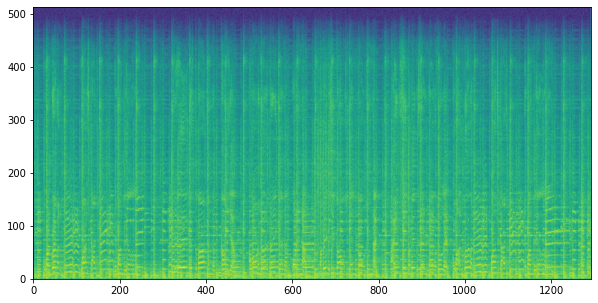

In [76]:
import matplotlib.pyplot as plt

spec = out_spec[0]
db_spec = db_converter(spec)
plt.figure(figsize = (10, 5)) # spectrogram size 조절
plt.imshow(db_spec, aspect = 'auto', origin = 'lower')
# spec에 DB을 적용
# DB는 Amplitude 측면에서 사람의 인식과 유사하게 형태를 변환한다

In [77]:
#MelScale 확인
# ??torchaudio.transforms.MelScale
# 굳이 실행에 추가하지는 않았다.

0.0 128
torch.Size([513, 128])


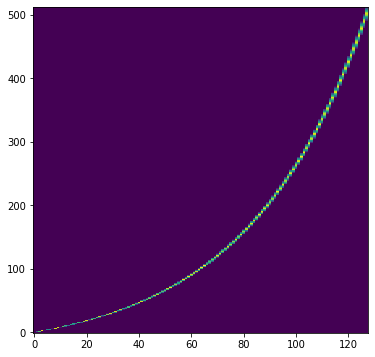

In [78]:
# mel_converter 확인
# mel_scale은 linear 하게 커지다가, 위로 갈수록 지수적으로 차이를 느낌
# mel_scale을 적용해 압축 / 우리가 원하는 부분을 관측 가능

print(mel_converter.f_min, mel_converter.n_mels)
print(mel_converter.fb.shape) # 513 * 128로 존재...  513 은 spectrogram을 거친 이후의 0 ~ 512Hz 표현 영역일 것
plt.figure(figsize = (6, 6))
plt.imshow(mel_converter.fb, aspect = 'auto', origin = 'lower', interpolation = 'nearest')
# 따라서 실제로는 513개의 data을 128개의 n_mels 로 변환하는 linear function 이라 할 수 있다.

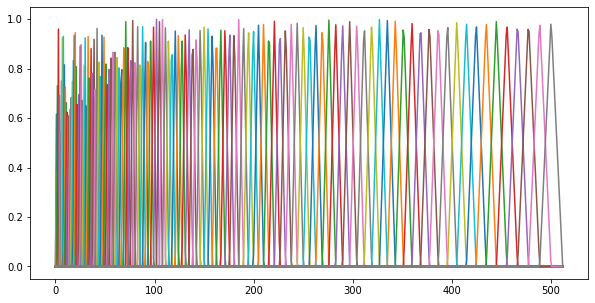

In [79]:
# 개인적으로 melspectrogram의 이해를 돕기 위해 추가한 코드입니다.

# mel_converter은 410 ~ 440 정도의 position 의 value 을
# mel scale 상 120 정도에 위치하도록 한다.

data = mel_converter.fb[400:450, 120]
#plt.plot(data)


# 아래 코드는 각 Mel scale 영역을 보여주며,
# 각 spectrogram 상 data가 어떻게 중첩되어 변환되는 지를 파악할 수 있다.
plt.figure(figsize = (10, 5))

for i in range(128):
  data = mel_converter.fb[:, i]
  plt.plot(data)

plt.show()

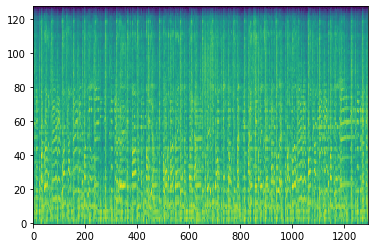

In [80]:
spec = spec_converter(y) # y는 위에서 설정한 wav_fns[0] 에 해당하는 data 이다.
mel_spec = mel_converter(spec)
mel_db_spec = db_converter(mel_spec)

# spectrogram 생성 - > melody scale로 spectrogram을 변경 -> db scale 로 각 amplitude을 변경
# db와 mel 상의 적용 순서에는 차이가 없나 ? orthogonal 하나 ?
# db는 log의 적용이므로, db -> mel의 경우 로그의 덧셈, 즉 내부에서 곱셈으로 취급되어 다른 결과가 나온다.
# 따라서 spectrogram -> mel -> db 적용의 순서로 수행해야 한다.

plt.imshow(mel_db_spec[0], aspect = 'auto', origin = 'lower', interpolation = 'nearest')

# 장르 classifier 구현

단순한 feed forward NN 형태로 구현해본다.

In [81]:
# 장르 classifier을 구현 / input은 mel_db_spectrogram이 될 것 (위 plt 상 128 * 12xx 쯤의 data) 

import torch.nn as nn
import torch

class GenreClassifier(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim = 10):
    super().__init__() # nn.Module에 대한 init 수행

    self.layer1 = nn.Linear(in_features = input_dim, out_features = hidden_dim) # input layer
    self.layer2 = nn.Linear(hidden_dim, hidden_dim) # hidden layer
    self.layer3 = nn.Linear(hidden_dim, output_dim) # output layer
    self.relu = nn.ReLU()


  # model을 call 할 때 바로 실행됨 / torch 에서는 계산 과정이 남기 때문에 중첩 가능하다
  def forward(self, x):
    x = self.layer1(x)
    x = self.relu(x)
    x = self.layer2(x)
    x = self.relu(x)
    x = self.layer3(x)
    
    # x = self.relu(self.layer1(x)) 와 같은 형태도 가능하다.

    return x

# spectrogram 상 3 frame을 input으로 갖는 model을 설정한다.
model = GenreClassifier(input_dim = 128*3, hidden_dim = 64)

In [82]:
# 별도의 reshaping([1, 128, ...] to [128, ...])은 수행하지 않음, batch 할 때 사용 가능하기 때문

print("mel_db_spec shape :", mel_db_spec.shape)
test_input = mel_db_spec[:, :, 600:603]
print("test_input shape :", test_input.shape)
#model(test_input) # 이 자체로 수행한다면, test_indut -> [1, 128, 3] 형태이기 때문에, input인 128 * 3 에 적합하지 않음.
print()

# 따라서 아래와 같이 flatten 작업 수행
flattened_test_input = test_input.reshape(test_input.shape[0], test_input.shape[1] * test_input.shape[2])
flattened_test_input.shape

# NN에 forward로 실행했을 대의 결과값
model(flattened_test_input)
# 아직까지의 model은 학습 등이 수행되지 않았으며, model의 random initial value로만 3frame을 인식하여
# 결과값을 도출한 형태이다. 추가로 결과 값은 단순한 output layer의 weighted sum으로 확률 값이 아니다.

mel_db_spec shape : torch.Size([1, 128, 1293])
test_input shape : torch.Size([1, 128, 3])



tensor([[ 0.5408,  1.1258,  0.6315,  0.7358,  0.0360, -1.3873,  1.4546, -2.2300,
         -0.1076,  0.3380]], grad_fn=<AddmmBackward0>)

#Dataset class 구현

Dataset class는 모든 wav_fns의 path를 보유하고 있으며,

__len__ 로 총 데이터 길이를 알 수 있으며,

 __getitem__ 으로 .wav file의 torchaudio load 결과를 바탕으로 

 sr * num_slice_len 만큼의 data 와 해당 data의 label을 return 해준다.

In [83]:
# data set class 정의 / 각 data에서 random 시간의 일정 frame(1초)을 output으로 수행할 수 있도록
import random

class Dataset:
  def __init__(self, data_dir, num_slice_len = 1, sr = 22050):
    self.num_slice_len = num_slice_len
    self.sr = sr

    # .wav data 불러오기
    self.data_dir = Path(data_dir)
    self.wav_fns = sorted(list(self.data_dir.rglob('*.wav')))
    print(f"Total {len(self.wav_fns)} pieces excist in the directory (recursively)")

    # 모든 .wav file의 장르를 파악하여, 장르 : number 의 dictionary을 구현
    self.genre_names = sorted(list(set([x.parent.name for x in wav_fns])))
    self.gen2idx = {name : i for i, name in enumerate(self.genre_names)}

  # 총 .wav data 개수
  def __len__(self):
    return len(self.wav_fns)

  # list like한 형태로 사용할 수 있도록
  def __getitem__(self, idx):
    # return audio and label
    wav_fn = self.wav_fns[idx] # Path class data
    y, sr = torchaudio.load(wav_fn)

    # stereo data의 경우 평균값을 도출하며 / mono의 경우에도 dim 1을 제거할 수 있다.
    # 원래는 shape = (1, ~~) / (2, ~~) 이엇던 것을 1차원 data로 변경해주는 작업이다.
    y = y.mean(dim = 0)

    # serial data인지 확인
    assert y.ndim == 1

    # sr 이 class 상의 sr과 load한 .wav file의 sr이 동일한지 확인
    assert self.sr == sr

    random_slice_position = random.randint(0, y.shape[0] - 1 - sr * self.num_slice_len)
    sliced = y[random_slice_position : random_slice_position + sr * self.num_slice_len]
  # 해당 .wav file의 path에서 parent는 해당 장르를 의미한다. 따라서 이를 통해 label울 파악할 수 있다.
    label = self.gen2idx[wav_fn.parent.name]
    
    return sliced, label
    
    # 교수님이 설명하실 때 사용했던 코드
    #ipd.Audio(y, rate = sr)
    #return self.wav_fns[idx]

# class instance 생성
dataset = Dataset(data_dir = 'genres/', num_slice_len = 1)

# class의 method 등이 잘 작동하는지 확인하는 부분
#print("Length of dataset :",len(dataset))
print("dataset[0]'s value :", dataset[0])
print(dataset[0][0].shape) # dataset[0]은 (data, label) 인 tuple 이다.
print("genre_name :", dataset.genre_names[dataset[0][1]])
# 0번째 data의 장르를 string으로 확인하는 방법을 마지막 줄에 포함하였다.

Total 1000 pieces excist in the directory (recursively)
dataset[0]'s value : (tensor([0.1666, 0.1660, 0.1588,  ..., 0.0934, 0.0884, 0.0817]), 0)
torch.Size([22050])
genre_name : blues


In [84]:
# dataset에 대해 batch로 size = 8을 잡았을 때 결과값을 확인

dataloader = torch.utils.data.DataLoader(dataset, batch_size = 8, shuffle = True)

batch = next(iter(dataloader)) #batch 하나 뽑아내서 확인하기.

print(batch)
print(type(batch))
print("batch size :", len(batch)) # [[list of data], [list of label]]
print("batch[0] size :", len(batch[0])) # [list of data]
# print("batch[1] size :", len(batch[1])) # [list of label]

[tensor([[ 4.9255e-02,  4.9377e-02,  5.1666e-02,  ..., -6.9275e-03,
         -6.2561e-03, -5.4626e-03],
        [ 3.4576e-02, -2.7161e-03, -1.5900e-02,  ..., -5.3589e-02,
         -3.8147e-02, -1.0593e-01],
        [-3.8757e-02, -4.2236e-02, -3.3417e-02,  ...,  3.0414e-01,
          2.6746e-01,  2.1100e-01],
        ...,
        [-1.1188e-01, -9.5673e-02, -4.8035e-02,  ..., -1.1398e-01,
         -2.1210e-01,  9.1553e-05],
        [ 2.5726e-02,  1.9897e-02,  1.3947e-02,  ..., -3.5620e-01,
         -1.6568e-01, -5.1727e-02],
        [ 1.7975e-02,  2.9022e-02,  2.0844e-02,  ...,  1.1420e-01,
          1.3602e-01,  1.1801e-01]]), tensor([1, 9, 6, 6, 8, 7, 4, 6])]
<class 'list'>
batch size : 2
batch[0] size : 8


# Spectrogram class 생성

spectrogram 생성 과정은 parameter을 제외하고 위와 동일하다.

In [85]:
# Audio serial data를 spectrogram으로 변형하는 부분이다.

class Audio2Spec(nn.Module):
  def __init__(self, sr, n_fft, n_mels):
    super().__init__()

    self.spec_converter = torchaudio.transforms.Spectrogram(n_fft = n_fft)
    self.mel_converter = torchaudio.transforms.MelScale(sample_rate = sr, f_max = 4000, n_stft = n_fft//2 + 1, n_mels = n_mels)
    self.db_converter = torchaudio.transforms.AmplitudeToDB() 

  
  def forward(self, x):
    mel_spec = self.mel_converter(self.spec_converter(x))
    db_mel_spec = self.db_converter(mel_spec)

    return db_mel_spec

audio2spec = Audio2Spec(sr = 22050, n_fft = 2048, n_mels = 64)
batch = batch[0] # 위에서 batch에 label을 포함하도록 구현했기 때문에, data list만 포함하도록 변경해 준다.

spec_batch = audio2spec(batch)
spec_batch.shape

torch.Size([8, 64, 22])

# Genre classifier 구현

위의 classifier에 추가하여, converter을 포함해 해당 classifier 내부에서 dataset 의 __getitem__ 결과의 y값을 바로 사용할 수 있도록 변경한다.

In [86]:
# classifier 재구현, spectrogram 생성 부분을 classifier model 내부에 추가해 준다.
# input : label이 없는 8 data(8, 22050) 으로 이루어진 batch data
# 

import torch.nn as nn
import torch

class GenreClassifierWithSpec(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim = 10):
    super().__init__() # nn.Module에 대한 init 수행

    self.spec_converter = Audio2Spec(sr = 22050, n_fft = 2048, n_mels = 64)
    self.layer1 = nn.Linear(in_features = input_dim, out_features = hidden_dim) # input layer
    self.layer2 = nn.Linear(hidden_dim, hidden_dim) # hidden layer
    self.layer3 = nn.Linear(hidden_dim, output_dim) # output layer


  def forward(self, x):
    # batch input인 경우 8 * 22050
    # 이를 spec_convterter을 거치며 8*64*22 data로 변환된다. (1초에 해당하는 spectrogram 8개) 
    x = self.spec_converter(x) / 50
    # / 50 을 하는 이유는 spectrogram data 상 최대값이 49.xx이며, 
    # NN 상에서 input : -1 ~ 1 범위를 맞추어 주기 위해 수행한다.
    # 초기값 설정 문제와도 연관된다.

    x = torch.flatten(x, 1) # (8, 64, 22) data을 (8, 64*22) data로 flattening 한다.

    x = self.layer1(x)
    x = torch.relu(x)
    x = self.layer2(x)
    x = torch.relu(x)
    x = self.layer3(x)

    return x


# 위에서 flattening 한 size가 input size가 된다.
model = GenreClassifierWithSpec(64*22, 64)

print("output shape :", model(batch).shape)
print()
print("output :", model(batch)[:, :5]) # 시각화의 편의상 0~4 번째의 weighted sum 만 출력하도록 했다. (실제로는 10개의 값이 존재할 것)

# 여기에서 output 또한 확률 값은 아니며, 각 8개 data 각각의 weighted sum이라 볼 수 있다.

output shape : torch.Size([8, 10])

output : tensor([[-0.0799, -0.0089,  0.0980,  0.0112, -0.0131],
        [-0.0773, -0.0129,  0.1001, -0.0392,  0.0110],
        [-0.0887, -0.0134,  0.0901, -0.0495,  0.0058],
        [-0.1036, -0.0197,  0.0724, -0.0324,  0.0436],
        [-0.0993, -0.0176,  0.0851,  0.0046,  0.0004],
        [-0.0847, -0.0151,  0.0853, -0.0285,  0.0148],
        [-0.0840, -0.0166,  0.1044, -0.0432, -0.0037],
        [-0.0869, -0.0187,  0.0785, -0.0428,  0.0222]],
       grad_fn=<SliceBackward0>)


# Train / Valid / Test division
Train set : Model parameter 학습

Valid / Test set을 나누는 이유
  - Validation set은 Hyperparameter을 결정하기 위해 활용
  - 모델의 구조 (Layer ? / 레이어 사이즈?)
  - 얼마나 오래 학습할 것인지 (overfitting이 일어나는 순간이 언제인지, 몇 번 학습한 모델을 사용할건지)
  - learning rate의 결정

Train set 뿐만 아닌, Test set overfitting problem 존재

서로 겹치지 않도록 주의해야 함
  - leakage가 생기면 실험의 신뢰성이 없어짐
  - 음악의 경우, 같은 아티스트의 곡이 여러 split에 존재하는 것 등

#Data set division

train / valid / test 를 각각 700 / 150 / 150 개로 랜덤하게 나눈다.

In [87]:
trainset, validset, testset = torch.utils.data.random_split(dataset, (700, 150, 150))
# 위 코드는 random sampling 될 것이다.

# 아래 부분은 교수님이 수업때 하신 추가 설명 부분입니다.


# train set 뿐만 아니라, test set의 overfitting 또한 발생할 수 있음.
# 따라서 validation set을 설정

# cross validation - data set의 division을 여러 번 변경
# ex) Train/Valid/Test => 1/2/3 , 2/3/1, ,,, 등으로 나누어 구현

# model의 결정 기준 -> validation set을 바탕으로 결정해야 한다.
# test set의 정확도는 평가 기준이 되면 안되며, 모델의 적확도를 측정하는 척도로만 사용해야 한다.
# (to avoid test set overfitting)

trainset.indices[:10] # train set 10개 확인

[485, 849, 845, 250, 218, 927, 528, 899, 471, 434]

# Train / Validation 과정 구현

총 5번의 epoch에서 수행한다.

각 batch size는 16으로 설정했지만, 마지막 batch의 경우 size가 더 작을 수 있다.

train은 각 batch(mini_batch) 마다의 loss와 accuracy를 계산하며,

valid는 각 epoch 마다 loss와 accuracy를 계산하여 비교한다.

In [88]:
# 학습 과정 구현 

# model accuracy 계산하는 함수 구현
def get_accuracy(pred, label):
  # pred.ndim == 2
  # pred.shape == (Batch_size, Num_classes)
  predicted_class = pred.argmax(dim = 1).cpu() # 각 sample에 대해 max value에 해당하는 index 선택
  is_correct = predicted_class == label
  return is_correct.sum() / label.shape[0]


from tqdm.auto import tqdm

model = GenreClassifierWithSpec(64*22, 64) # NN model 변수 사용
dataset = Dataset(data_dir='genres/')

trainset, validset, testset = torch.utils.data.random_split(dataset, [700, 150, 150])
dataloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True)
valid_loader = torch.utils.data.DataLoader(validset, batch_size=16, shuffle=False)

print(model.parameters())
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # optimizer 정의
n_epoch = 5

model.train()
model.to('cuda')
loss_record = [] # loss 추이를 확인하기 위해 loss 값 저장
accuracy_record = []

# valid result 을 저장하기 위해
valid_loss_record = []
valid_accuracy_record = []


for i in tqdm(range(n_epoch)):

  # train 과정
  for batch in tqdm(dataloader, leave=False): # train set으로 만든 batch를 사용
    audio, label = batch
    pred = model(audio.cuda()) # audio data들의 tensor을 바탕으로 Forward 연산
    prob = pred.softmax(dim=1) # 각 audio data들의 output (16 * 10) 에 softmax 적용
    prob_of_correct_class = prob[torch.arange(len(label)), label]
    nll = -torch.log(prob_of_correct_class + 1e-8) # NLL 계산
    loss = nll.mean() # 모든 NLL의 평균값을 loss 로 적용
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    loss_record.append(loss.item())
    accuracy_record.append(get_accuracy(pred, label))

  # Get validation result
  # How frequent to get validation is on your choice.
  # we don't train model during the validation
  with torch.inference_mode(): # 학습 상황이 아님을 의미한다.
    # any torch computation under this indent
    # will ignore gradients

    # 전체 batch 의 결과를 저장하기 위한 변수들
    valid_loss = 0
    valid_accuracy = 0
    num_valid_samples = 0

    # validation 과정
    for batch in tqdm(valid_loader, leave = False):
      audio, label = batch
      pred = model(audio.cuda()) # audio data들의 tensor을 바탕으로 Forward 연산
      prob = pred.softmax(dim=1) # 각 audio data들의 output (16 * 10) 에 softmax 적용
      prob_of_correct_class = prob[torch.arange(len(label)), label]
      nll = -torch.log(prob_of_correct_class + 1e-8) # NLL 계산
      #loss = nll.mean() # 모든 NLL의 평균값을 loss 로 적용
      
      valid_loss += nll.sum().item()
      valid_accuracy += get_accuracy(pred, label) * len(label)
      num_valid_samples += len(label)
      #loss.backward()
      #optimizer.step()
      #optimizer.zero_grad()
      
    # 모든 batch을 확인한 이후, 값을 저장하는 형태이다. 
    valid_loss /= num_valid_samples
    valid_accuracy /= num_valid_samples
    valid_loss_record.append(valid_loss) # 여기에서 측정은 각 batch 가 아닌, 각 epoch마다의 측정이다.
    valid_accuracy_record.append(valid_accuracy) # 위와 동일하다.
    # print(f"valid loss : {valid_loss}, valid_accuracy : {valid_accuracy}") value 확인을 위한 코드.
  

Total 1000 pieces excist in the directory (recursively)
<generator object Module.parameters at 0x7f92375f7580>


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [89]:
# 100 번째 data에 대해 prediction 수행해보기 // 중요한 부분은 아닙니다.

audio, label = dataset[100]
test_pred = model(audio.unsqueeze(0).cuda()) # model input 에 맞추어 
print(test_pred.softmax(dim=-1))
print()

predicted_class_idx = test_pred.argmax(dim=1).cpu().item()
print("prediction genre :", dataset.genre_names[predicted_class_idx])

tensor([[0.1334, 0.1058, 0.1425, 0.0376, 0.0344, 0.3060, 0.0058, 0.0567, 0.0971,
         0.0807]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

prediction genre : jazz


# test / valid 결과 시각화

각각 파랑은 test, 주황은 valid set에 대한 계산 결과

위는 loss 값의 추이, 아래는 accuracy 값의 추이

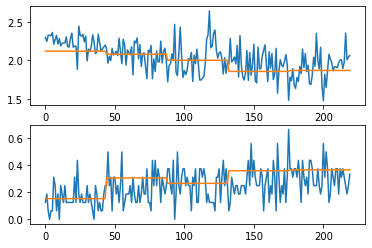

In [90]:
# 학습을 수행할 때 loss 결과값의 추이를 확인

# valid record는 5개, test record는 5 * 700 / 15 = 44 * 5 
# 따라서 valid record와 test record을 같이 plot 할 때 x축 길이를 맞추기 위해
# valid record 길이를 늘리는 작업을 수행해 준다. 

plt.subplot(2, 1, 1)
valid_loss_record_reshape = []

for i in valid_loss_record: 
  for j in range(44):
    valid_loss_record_reshape.append(i)
    
plt.plot(loss_record)
plt.plot(valid_loss_record_reshape)

# accuracy 비교, 위와 동일
plt.subplot(2, 1, 2)
valid_accuracy_record_reshape = []
for i in valid_accuracy_record:
  for j in range(44):
    valid_accuracy_record_reshape.append(i)
    
plt.plot(accuracy_record)
plt.plot(valid_accuracy_record_reshape)


# Validation 이후 hyperparameter 변경

- input data size
- hidden layer size
- model layer
- epoch value
- loss function
- learning rate
- batch size

  등을 변경해볼 수 있다.

  아래 코드는 input data size, hidden layer size, model layer, epoch을 변경했다.

In [91]:
# dataset 재설정, 1초에서 3초로 변경

dataset = Dataset(data_dir = 'genres/', num_slice_len = 3) # 3초에 해당하는 input으로 변경
audio2spec(dataset[3][0]).shape # 3초인 경우 model의 input size가 어떻게 되는지 파악하기 위한 코드

Total 1000 pieces excist in the directory (recursively)


torch.Size([64, 65])

In [92]:
# model layer 재설정, hidden layer 2개 -> 4개로

class GenreClassifierWithSpec(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim = 10):
    super().__init__() # nn.Module에 대한 init 수행

    self.spec_converter = Audio2Spec(sr = 22050, n_fft = 2048, n_mels = 64)
    self.layer1 = nn.Linear(in_features = input_dim, out_features = hidden_dim) # input layer
    self.layer2 = nn.Linear(hidden_dim, hidden_dim) # hidden layer
    self.layer3 = nn.Linear(hidden_dim, hidden_dim) # hdden layer added
    self.layer4 = nn.Linear(hidden_dim, hidden_dim) # hidden layer added
    self.layer5 = nn.Linear(hidden_dim, output_dim) # output layer


  def forward(self, x):
    # batch input인 경우 8 * 22050
    # 이를 spec_convterter을 거치며 8*64*22 data로 변환된다. (1초에 해당하는 spectrogram 8개) 
    x = self.spec_converter(x) / 50
    # / 50 을 하는 이유는 spectrogram data 상 최대값이 49.xx이며, 
    # NN 상에서 input : -1 ~ 1 범위를 맞추어 주기 위해 수행한다.
    # 초기값 설정 문제와도 연관된다.

    x = torch.flatten(x, 1) # (8, 64, 22) data을 (8, 64*22) data로 flattening 한다.

    x = self.layer1(x)
    x = torch.relu(x)
    x = self.layer2(x)
    x = torch.relu(x)
    x = self.layer3(x)
    x = torch.relu(x)
    x = self.layer4(x)
    x = torch.relu(x)
    x = self.layer5(x)

    return x

In [93]:
# input, hidden, epoch을 변경하는 코드이다.

model = GenreClassifierWithSpec(64*65, 128) # input size 변경 22 -> 65, 위 결과를 바탕으로 / hidden layer 또한 64 -> 128 변경

trainset, validset, testset = torch.utils.data.random_split(dataset, [700, 150, 150])
dataloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True)
valid_loader = torch.utils.data.DataLoader(validset, batch_size=16, shuffle=False)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # optimizer 정의
n_epoch = 10 # 학습 횟수 변경 5-> 10

In [94]:
####### 아래 코드는 위 과정과 동일 #######

model.train()
model.to('cuda')
loss_record = [] # loss 추이를 확인하기 위해 loss 값 저장
accuracy_record = []

# valid result 을 저장하기 위해
valid_loss_record = []
valid_accuracy_record = []


for i in tqdm(range(n_epoch)):

  # train 과정
  for batch in tqdm(dataloader, leave=False): # train set으로 만든 batch를 사용
    audio, label = batch
    pred = model(audio.cuda()) # audio data들의 tensor을 바탕으로 Forward 연산
    prob = pred.softmax(dim=1) # 각 audio data들의 output (16 * 10) 에 softmax 적용
    prob_of_correct_class = prob[torch.arange(len(label)), label]
    nll = -torch.log(prob_of_correct_class + 1e-8) # NLL 계산
    loss = nll.mean() # 모든 NLL의 평균값을 loss 로 적용
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    loss_record.append(loss.item())
    accuracy_record.append(get_accuracy(pred, label))

  # Get validation result
  # How frequent to get validation is on your choice.
  # we don't train model during the validation
  with torch.inference_mode(): # 학습 상황이 아님을 의미한다.
    # any torch computation under this indent
    # will ignore gradients

    # 전체 batch 의 결과를 저장하기 위한 변수들
    valid_loss = 0
    valid_accuracy = 0
    num_valid_samples = 0

    # validation 과정
    for batch in tqdm(valid_loader, leave = False):
      audio, label = batch
      pred = model(audio.cuda()) # audio data들의 tensor을 바탕으로 Forward 연산
      prob = pred.softmax(dim=1) # 각 audio data들의 output (16 * 10) 에 softmax 적용
      prob_of_correct_class = prob[torch.arange(len(label)), label]
      nll = -torch.log(prob_of_correct_class + 1e-8) # NLL 계산
      #loss = nll.mean() # 모든 NLL의 평균값을 loss 로 적용
      
      valid_loss += nll.sum().item()
      valid_accuracy += get_accuracy(pred, label) * len(label)
      num_valid_samples += len(label)
      #loss.backward()
      #optimizer.step()
      #optimizer.zero_grad()
      
    # 모든 batch을 확인한 이후, 값을 저장하는 형태이다. 
    valid_loss /= num_valid_samples
    valid_accuracy /= num_valid_samples
    valid_loss_record.append(valid_loss) # 여기에서 측정은 각 batch 가 아닌, 각 epoch마다의 측정이다.
    valid_accuracy_record.append(valid_accuracy) # 위와 동일하다.

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

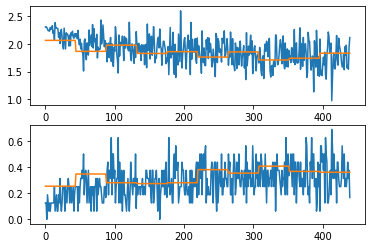

In [95]:
####### 아래 코드는 위 과정과 동일 #######

plt.subplot(2, 1, 1)
valid_loss_record_reshape = []

for i in valid_loss_record: 
  for j in range(44):
    valid_loss_record_reshape.append(i)
    
plt.plot(loss_record)
plt.plot(valid_loss_record_reshape)

# accuracy 비교, 위와 동일
plt.subplot(2, 1, 2)
valid_accuracy_record_reshape = []
for i in valid_accuracy_record:
  for j in range(44):
    valid_accuracy_record_reshape.append(i)
    
plt.plot(accuracy_record)
plt.plot(valid_accuracy_record_reshape)

# validation value에서 큰 차이를 보이지는 않는다.

# Test 과정
위에서 나눈 150개의 test data에 대해 확률을 구하는 코드를 추가했다.

In [96]:
torch.inference_mode()
answer_output = [data[1] for data in testset] # 정답 값 저장
testset = torch.stack([data[0] for data in testset]) # test data 형태 알맞게 변형시키기
test_output = torch.argmax(model(testset.cuda()), dim = 1)

correct = 0  # 정답 개수 누적을 위한 변수
for i in range(len(answer_output)):
  if answer_output[i] == test_output[i]:
    correct += 1

print(f"test accuracy :{correct / len(answer_output) * 100 : .2f}%")

test accuracy : 42.67%
